RSI 전략

In [42]:
from algobot.CoinInstrument import CoinInstrument

In [43]:
ci = CoinInstrument("KRW-BTC", count=24, interval="minute60")

In [44]:
ci.rsi(14).tail()

,RSI
2022-06-09 16:00:00+09:00,48.428291
2022-06-09 17:00:00+09:00,61.574618
2022-06-09 18:00:00+09:00,63.005780
2022-06-09 19:00:00+09:00,51.693002
2022-06-09 20:00:00+09:00,40.125000


In [45]:
from algobot.BackTester import RSIBackTester

In [46]:
ci = CoinInstrument("KRW-BTC", count=365*24*2, interval="minute60")

In [47]:
rsi_tester = RSIBackTester(coinInstrument=ci, periods=14, upper=80, lower=20)

In [48]:
rsi_tester.test_strategy()

(1.123489, -2.17249)

In [49]:
rsi_tester.optimize_parameters((5,30,1), (70,80,1), (10,40,1))

(array([ 6., 74., 39.]), 9.381341)

In [50]:
rsi_tester.set_parameters(6, 74, 39)

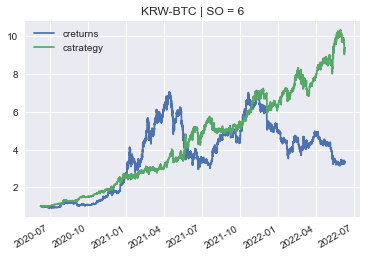

In [51]:
rsi_tester.plot_returns()

<AxesSubplot:>

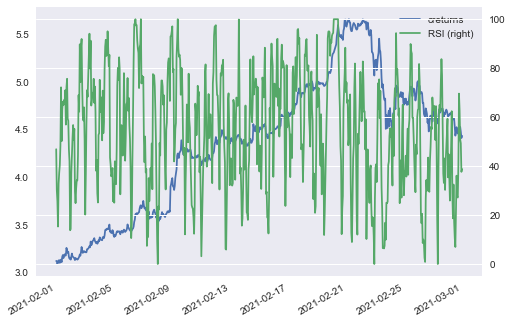

In [52]:
rsi_tester.results.loc["2021-02":"2021-02", ["creturns", "RSI"]].plot(secondary_y="RSI")

<AxesSubplot:>

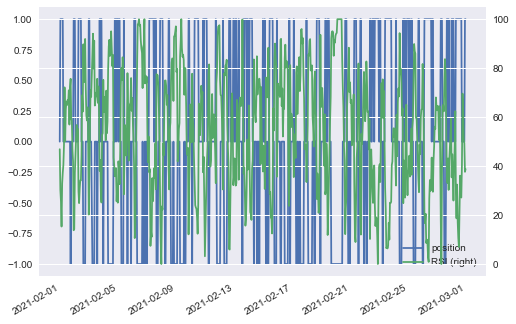

In [53]:
rsi_tester.results.loc["2021-02":"2021-02", ["position", "RSI"]].plot(secondary_y="RSI")

In [54]:
from algobot.BackTester import MACDBackTester

In [55]:
macd_tester = MACDBackTester(coinInstrument=ci)

In [56]:
macd_tester.optimize_parameters((10,20,1), (20,100, 1), (5,10,1))

(array([19., 43.,  9.]), 9.001225)

combine 전략

In [57]:
from algobot.BackTester import CombineMACDRSIBackTester
# from algobot.CoinInstrument import CoinInstrument

In [58]:
# ci = CoinInstrument("KRW-BTC", count=10*24*2, interval="minute60")

In [59]:
tester = CombineMACDRSIBackTester(coinInstrument=ci)

In [60]:
# def optimize_parameters(self, ema_s_range, ema_l_range, signal_window_range, rsi_periods_range, rsi_upper_range, rsi_lower_range):
# tester.optimize_parameters((10,15,1),(25,30,1),(8,10),(15,25,1),(70,80,1),(20,30,1))  # bad.. 각 알고리즘의 최적의 값을 찾아 넣는게 나음

In [96]:
tester.test_strategy()
# tester.set_parameters()

(4.718239, 1.410323)

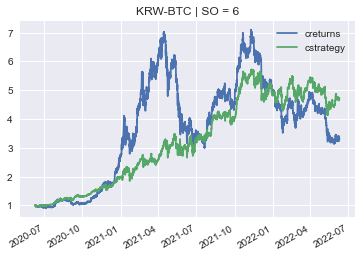

In [97]:
tester.plot_returns()

# 83. 소개

## 1. SO 전략 이해 및 코드 작성, 최적화
## 2. 거래/트랜젝션 비용의 중요성
## 3. OOP 프레임워크 작성

# 84. 데이터 가져오기

In [63]:
!pip install pyupbit

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyupbit
plt.style.use("seaborn")

In [65]:
df = pyupbit.get_ohlcv("KRW-BTC", interval="day", count=5*365)
df

,open,high,low,close,volume,value
2017-09-25 09:00:00+09:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
2017-09-26 09:00:00+09:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2017-09-27 09:00:00+09:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
2017-09-28 09:00:00+09:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...
2022-06-05 09:00:00+09:00,37916000.0,38300000.0,37608000.0,37972000.0,1320.221687,4.998600e+10
2022-06-06 09:00:00+09:00,37974000.0,39952000.0,37966000.0,39532000.0,4372.224579,1.720418e+11
2022-06-07 09:00:00+09:00,39532000.0,39797000.0,37500000.0,39398000.0,7886.332468,3.032502e+11
2022-06-08 09:00:00+09:00,39366000.0,39599000.0,38128000.0,38581000.0,5152.829444,1.993505e+11


<AxesSubplot:title={'center':'KRW-BTC'}>

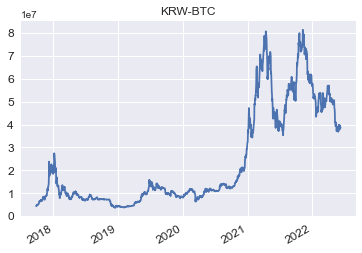

In [66]:
df.close.plot(figsize=(6,4), title = "KRW-BTC", fontsize=12)

In [67]:
df["returns"] = np.log(df.close.div(df.close.shift(1)))

# 85. SO 전략의 정의

## 구성
- 0~100으로 구성된 2개의 선으로 구성
- Fast Stochastic Indicator(%K line)
- Slow Stochastic Indicator(%D line)

## 계산 방법
- %K
<img src="../data/img/stochastic_k.png" width=1000 />

In [68]:
periods = 14

In [69]:
df["roll_low"] = df.low.rolling(periods).min()
df["roll_high"] = df.high.rolling(periods).max()
df.tail(30)

,open,high,low,close,volume,value,returns,roll_low,roll_high
2022-05-11 09:00:00+09:00,41044000.0,43980000.0,39088000.0,40290000.0,31967.297187,1.328765e+12,-0.018590,39088000.0,51299000.0
2022-05-12 09:00:00+09:00,40263000.0,41178000.0,37000000.0,39243000.0,23389.063427,9.115180e+11,-0.026330,37000000.0,50999000.0
2022-05-13 09:00:00+09:00,39246000.0,41324000.0,38777000.0,39270000.0,12398.918801,4.983739e+11,0.000688,37000000.0,50999000.0
2022-05-14 09:00:00+09:00,39270000.0,40243000.0,38400000.0,39967000.0,5512.195620,2.170088e+11,0.017593,37000000.0,50999000.0
2022-05-15 09:00:00+09:00,39967000.0,41000000.0,39270000.0,40906000.0,4277.655034,1.706726e+11,0.023223,37000000.0,50999000.0
2022-05-16 09:00:00+09:00,40902000.0,40940000.0,38620000.0,39256000.0,5678.833853,2.243704e+11,-0.041172,37000000.0,50999000.0
2022-05-17 09:00:00+09:00,39260000.0,39900000.0,38416000.0,39259000.0,5356.753182,2.105359e+11,0.000076,37000000.0,50999000.0
2022-05-18 09:00:00+09:00,39260000.0,39464000.0,37001000.0,37099000.0,6367.452230,2.430866e+11,-0.056591,37000000.0,50832000.0
2022-05-19 09:00:00+09:00,37100000.0,39085000.0,37000000.0,38780000.0,6407.341868,2.429746e+11,0.044315,37000000.0,47800000.0
2022-05-20 09:00:00+09:00,38781000.0,39298000.0,37267000.0,37762000.0,5865.610376,2.252696e+11,-0.026601,37000000.0,47130000.0


<AxesSubplot:>

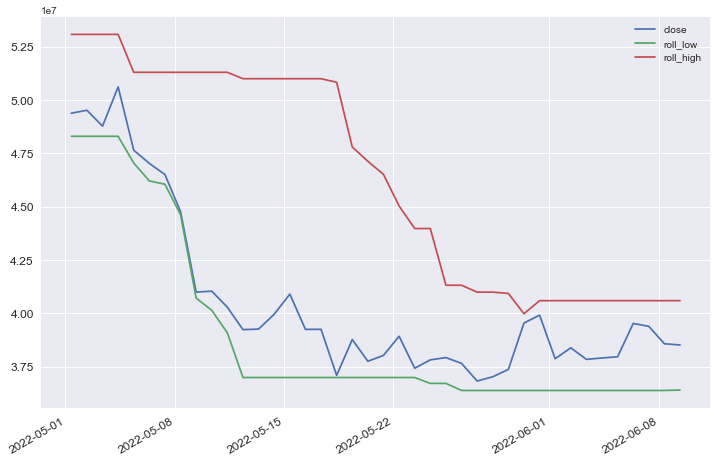

In [70]:
df.loc["2022/05":, ["close", "roll_low", "roll_high"]].plot(figsize=(12,8), fontsize=12)

In [71]:
df["K"] = (df.close - df.roll_low)/(df.roll_high - df.roll_low) * 100

<AxesSubplot:>

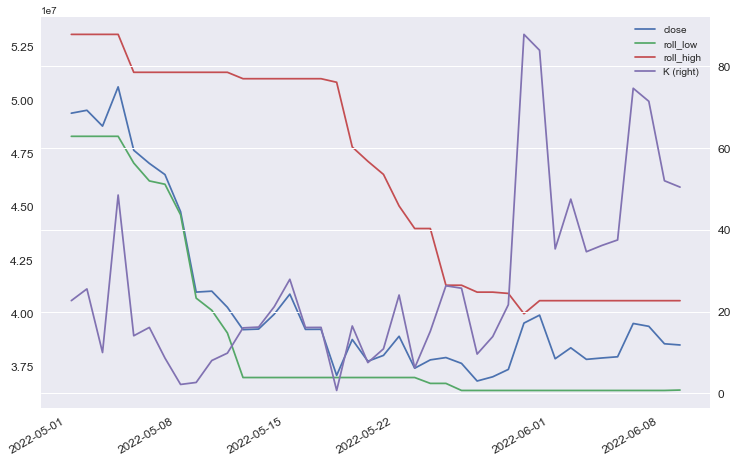

In [72]:
df.loc["2022/05":, ["close", "roll_low", "roll_high", "K"]].plot(figsize=(12,8), fontsize=12, secondary_y="K")

In [73]:
d_window = 3
df["D"] = df.K.rolling(d_window).mean()

In [74]:
df["position"] = np.where(df["K"] > df["D"], 1, -1)

In [75]:
df["strategy"] = df.position.shift(1) * df["returns"]

In [76]:
df.dropna(inplace=True)

In [77]:
df["trades"] = df.position.diff().fillna(0).abs()

In [78]:
df.trades.value_counts()

0.0    1006
2.0     698
Name: trades, dtype: int64

In [79]:
df["creturns"] = df["returns"].cumsum().apply(np.exp)
df["cstrategy"] = df["strategy"].cumsum().apply(np.exp)

<AxesSubplot:>

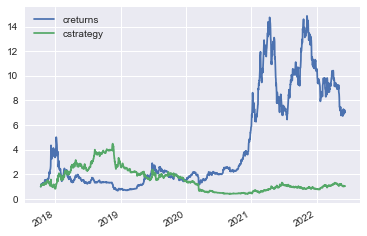

In [80]:
df[["creturns", "cstrategy"]].plot(figsize=(6,4))

# 87. SO 백테스팅 클래스의 실행

In [81]:
import pandas as pd
import numpy as np
import pyupbit
import matplotlib.pyplot as plt
import datetime
import pytz


class CoinInstrument:
    KST = datetime.timezone(datetime.timedelta(hours=9))

    def __init__(self, ticker, to=None, count=200, interval='day', period=0.5):
        self._data = None
        self.ticker = ticker
        self.interval = interval
        self.count = count
        self.to = to
        self.period = period
        self.load_data()
        self._data["log_returns"] = self.log_returns()

    def __repr__(self):
        return "CoinInstrument(ticker={}, to={}, count={}, interval={})".format(self.ticker, self.to,
                                                                                self.count, self.interval)

    # def to_origin(self):
    #     return self._utc_to_kst(self._to)
    #
    # def _kst_to_utc(self, to):
    #     return pd.to_datetime(to).to_pydatetime().replace(tzinfo=CoinInstrument.KST).astimezone(
    #         datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
    #
    # def _utc_to_kst(self, to):
    #     return pd.to_datetime(to).to_pydatetime().replace(tzinfo=datetime.timezone.utc).astimezone(
    #         CoinInstrument.KST).strftime("%Y-%m-%d %H:%M:%S")

    def load_data(self):
        self._data = pyupbit.get_ohlcv(self.ticker, self.interval, self.count, self.to, self.period)
        # self._data.index = self._data.index.tz_convert(None).tz_localize('Asia/Seoul')

    def symbol(self):
        return self.ticker

    def log_returns(self):
        return np.log(self._data.close / self._data.close.shift(1))

    def plot_prices(self, figsize=(12, 8)):
        self._data.close.plot(figsize=figsize)
        plt.title("Close chart : {}".format(self.ticker), fontsize=15)

    def plot_returns(self, kind="ts", figsize=(12, 8)):
        if kind == "ts":
            self._data.log_returns.plot(figsize=figsize)
            plt.title("Returns : {}".format(self.ticker), fontsize=15)
        elif kind == "hist":
            self._data.log_returns.hist(figsize=figsize, bins=int(np.sqrt(len(self._data))))
            plt.title("Frequency of Returns : {}".format(self.ticker), fontsize=15)

    def so(self, periods, d_window):
        raw = pd.DataFrame(index=self._data.index)
        raw["roll_low"] = self._data.low.rolling(periods).min()
        raw["roll_high"] = self._data.high.rolling(periods).max()
        raw["K"] = (self._data.close - raw.roll_low) / (raw.roll_high - raw.roll_low) * 100
        raw["D"] = raw.K.rolling(d_window).mean()
        return raw.loc[:, ["K", "D"]].copy()

In [82]:
from scipy.optimize import brute
import numpy as np
import pandas as pd

class SOBackTester:
  def __init__(self, symbol, to=None, count=200, interval='day', period=0.5, periods=14,d_window=3):
    self.results = None
    self._data = None
    self.coinInstrument = CoinInstrument(symbol, to, count, interval, period)
    self._periods = periods
    self._d_window = d_window
    self.load_data()

  def __repr__(self):
    return "SOBackTester(ticker={}, to={}, count={}, interval={}, periods={}, d_window={})"\
      .format(self.coinInstrument.ticker, self.coinInstrument.to, self.coinInstrument.count, self.coinInstrument.interval,
              self._periods, self._d_window)

  def load_data(self):
    self._data = self.coinInstrument.so(self._periods, self._d_window)

  def set_parameters(self, periods=None, d_window=None):
    if periods is not None:
      self._periods = periods
    if d_window is not None:
      self._d_window = d_window

    self.load_data()

  def test_strategy(self):
    data = self._data.copy()
    data["returns"] = self.coinInstrument.log_returns()
    data.dropna(inplace=True)
    data["position"] = np.where(data["K"] > data["D"], 1, -1)
    data["strategy"] = data["position"].shift(1) * data["returns"]
    data.dropna(inplace=True)
    data["creturns"] = data["returns"].cumsum().apply(np.exp)
    data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
    self.results = data
    perf = data["cstrategy"].iloc[-1]
    outperf = perf - data["creturns"].iloc[-1]
    return round(perf, 6), round(outperf, 6)

  def plot_returns(self):
    if self.results is None:
      print("No results to plot yet. Run a strategy")
    else:
      title = "{} | SO = {}/{}".format(self.coinInstrument.symbol(), self._periods, self._d_window)
      self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(6,4))

  def update_and_run(self, so=None):
    self.set_parameters(int(so[0]), int(so[1]))
    return -self.test_strategy()[0]

  def optimize_parameters(self, periods_range, d_window_range):
    opt = brute(self.update_and_run, (periods_range, d_window_range), finish=None)
    return opt, -self.update_and_run(opt)

In [83]:
soTester = SOBackTester("KRW-BTC", interval="day", count=5*365)
soTester.optimize_parameters((7,20,1), (2,10))

(array([ 7., 10.]), 244.172949)

In [84]:
soTester.set_parameters(7,10)

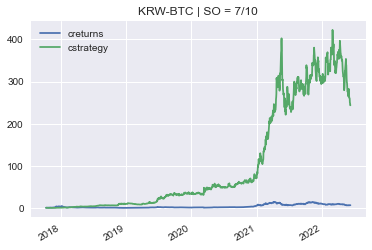

In [85]:
soTester.plot_returns()

# 88. OOP 도전 과제: SO 백테스팅 클래스

# 89. SO 전략의 대안과 해석

In [86]:
from algobot.BackTester import SOHorizonBackTester

In [87]:
tester = SOHorizonBackTester("KRW-BTC", count=365*24*2, interval="minute60", periods=14, upper=80, lower=20)

In [88]:
tester.test_strategy()

(0.920241, -2.394507)

In [89]:
tester.optimize_parameters((5,30,1), (70,80,1), (10,40,1))

(array([ 6., 70., 39.]), 4.718239)

In [90]:
tester.set_parameters(6, 70, 39)

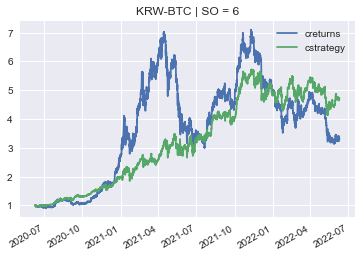

In [91]:
tester.plot_returns()

<AxesSubplot:>

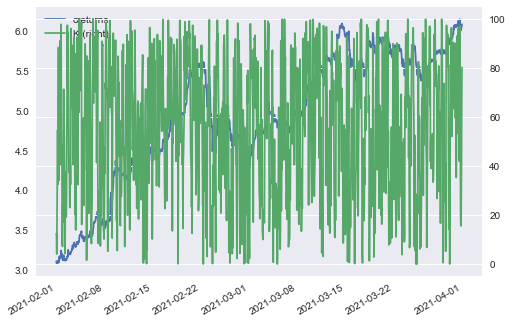

In [92]:
tester.results.loc["2021-02":"2021-03", ["creturns", "K"]].plot(secondary_y="K")

<AxesSubplot:>

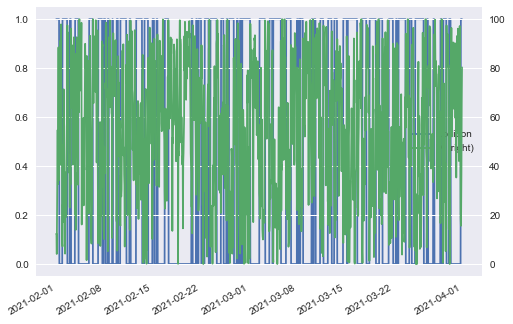

In [93]:
tester.results.loc["2021-02":"2021-03", ["position", "K"]].plot(secondary_y="K")